# Example State Machine Usage
## Inter-Machine Communication

In this example, suppose we have two state machines, representing a waiter and cook.

The waiter:

 - Takes customer order
 - Enters Order
 - Waits for Order
 - Gives order to customer
 
The chef:

 - Waits for an order
 - Prepares the order

In [189]:
from state_machine import StateMachine, State, Condition, AlwaysTrue, AlwaysFalse, Event, display_machine

### States

In [190]:
def take_customer_order(event, state):
    order = Event('order', event.payload)
    return order

In [191]:
def enter_customer_order(event, state):
    evt = Event( 'order entered', event.payload )
    state.logger.info( 'Sending order entered event' )
    state.notify_observers(evt)
    return evt

In [192]:
def give_order_to_customer(event, state):
    completed_order = event.payload
    state.logger.info( 'Gives %s to customer', completed_order)

In [193]:
waiter = StateMachine('waiter')

state_loiter                     = waiter.create_state('Loitering')
state_wait_for_customer_to_order = waiter.create_state('Wait For Customer to Order')
state_wait_for_order             = waiter.create_state('Wait For Chef To Cook')

state_loiter.add_transition_to(state_wait_for_customer_to_order, 'customer waves')
state_wait_for_customer_to_order.add_transition_to(state_wait_for_order, 'customer orders', action=enter_customer_order)
state_wait_for_order.add_transition_to(state_loiter, 'order complete', action=give_order_to_customer)

waiter.initial_state = state_loiter

INFO:default:Creating state of type <class 'state_machine.state.State'>
INFO:default:Creating state of type <class 'state_machine.state.State'>
INFO:default:Creating state of type <class 'state_machine.state.State'>


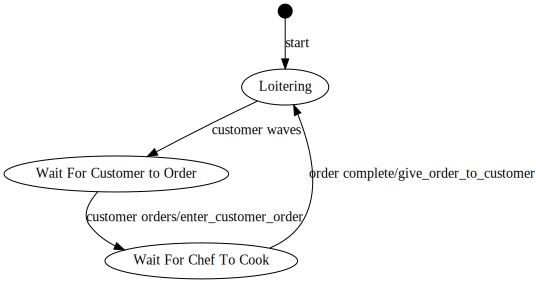

In [194]:
from state_machine import diagrams as diagrams
diagrams.display_machine(waiter)

In [195]:
waiter.initialise()

e = Event('customer waves')
waiter.notify(e)

e = Event('customer orders','pizza')
waiter.notify(e)

# Simulating the result from the chef
e = Event('order complete','cooked_pizza')
waiter.notify(e)

INFO:default:waiter transitioning to state State:Wait For Customer to Order
INFO:default:waiter transitioning to state State:Wait For Chef To Cook
INFO:default:Sending order entered event
INFO:default:waiter transitioning to state State:Loitering
INFO:default:Gives cooked_pizza to customer


Make the Chef state machine.

In [202]:
def when_order_entered(event, state):
    state.logger.info( 'chef''s when_order_received received %s'%event)

In [203]:
def when_order_complete(event, state): 
    state.logger.info('Chef has completed order')
    e = Event('order complete','cooked_pizza')
    state.notify_observers(e)

In [204]:
chef = StateMachine('chef')
chef_waits_for_order = chef.create_state('Chef Waits For Order')

chef_prepares_order  = chef.create_state('Chef Prepares Order')

chef_waits_for_order.add_transition_to(chef_prepares_order, 'order entered', action=when_order_entered )
chef_prepares_order.add_transition_to(chef_waits_for_order, 'time passes', action=when_order_complete)

chef.initial_state = chef_waits_for_order

waiter.register_observer('order entered', chef)
chef.register_observer('order complete', waiter)

INFO:default:Creating state of type <class 'state_machine.state.State'>
INFO:default:Creating state of type <class 'state_machine.state.State'>


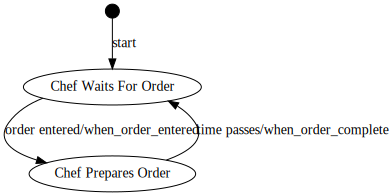

In [205]:
display_machine( chef )

Test the chef machine

In [206]:
chef.initialise()

e = Event('order entered','pizza')
chef.notify(e)

e = Event('time passes','10 minutes')
chef.notify(e)

INFO:default:chef transitioning to state State:Chef Prepares Order
INFO:default:chefs when_order_received received <Event name="order entered", payload=pizza>
INFO:default:chef transitioning to state State:Chef Waits For Order
INFO:default:Chef has completed order


Demonstrate interaction between the waiter and the chef...

The waiter sends an 'order entered' event. The chef picks this up and prepares the order.

When time passes, the chef completes the order, sending an 'order complete' order to the waiter.

In [207]:
waiter.initialise()
chef.initialise()

e = Event('customer waves')
waiter.notify(e)

e = Event('customer orders', 'pizza')
waiter.notify(e)

e = Event('time passes','10 minutes')
chef.notify(e)

INFO:default:waiter transitioning to state State:Wait For Customer to Order
INFO:default:waiter transitioning to state State:Wait For Chef To Cook
INFO:default:Sending order entered event
INFO:default:chef transitioning to state State:Chef Prepares Order
INFO:default:WhenOrderEntered received <Event name="order entered", payload=pizza>
INFO:default:chef transitioning to state State:Chef Prepares Order
INFO:default:chefs when_order_received received <Event name="order entered", payload=pizza>
INFO:default:chef transitioning to state State:Chef Waits For Order
INFO:default:Chef has completed order
INFO:default:waiter transitioning to state State:Loitering
INFO:default:Gives cooked_pizza to customer
